In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
cd gdrive/MyDrive/alph_stable/

/content/gdrive/MyDrive/alph_stable


Imports

In [ ]:
pip install ipdb

     |████████████████████████████████| 793 kB 5.2 MB/s 
     |████████████████████████████████| 381 kB 37.2 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=2537cbde2b1de5eeb44c3c0e4c1d75fd593ef90d5a41897a3514c09c5fcd12e7
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 

In [ ]:
import numpy as np
import os
import librosa
import soundfile as sf
import pickle as pkl

from jd_alpha_SpatialNMF import Alpha_MNMF

import argparse

import glob as glob

In [ ]:
nfft = 512

parser = argparse.ArgumentParser()
parser.add_argument(         '--gpu', type= int, default=     1, help='GPU ID')
parser.add_argument(       '--n_fft', type= int, default=  1025, help='number of frequencies')
parser.add_argument(    '--n_speaker', type= int, default=    2, help='number of speaker')
parser.add_argument(    '--n_mic', type= int, default=    2, help='number of microphones')
parser.add_argument(     '--n_basis', type= int, default=     6, help='number of basis')
parser.add_argument( '--n_iteration', type= int, default=   0, help='number of iteration')
parser.add_argument( '--n_inter', type= int, default=  50, help='number of intervals')
parser.add_argument( '--alpha',   dest='alpha', type=float, default=1.8,  help='Gaussian case (alpha=2)')
parser.add_argument( '--seed',   dest='seed', type=int, default=0,  help='random seed for experiments')
parser.add_argument('--data', type=str, default='dev', help='available: dev or test')
parser.add_argument('--nb_file', type=int, default=3, help='nb of file to separate')
parser.add_argument('--n_Th', type=int, default=72, help='number of sphere sampling')
parser.add_argument('--id_min', type=int, default=0, help='for chunk the file')
parser.add_argument('--id_max', type=int, default=1, help='for chunk the file')
parser.add_argument('--type', type=str, default="anechoic", help='reverb or anechoic')
parser.add_argument('--update_psi',   dest='update_psi', action='store_true',  help='updating Psi matrix or not ?')
parser.add_argument('--oracle',   dest='oracle', default=True, action='store_true',  help='M step or not ?')
parser.add_argument('-f')
args = parser.parse_args()

In [ ]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  10604      0 --:--:-- --:--:-- --:--:-- 10604
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


Main code

Use GPU 1
filtrage iteration = 0
filtrage iteration = 1
filtrage iteration = 2
filtrage iteration = 3
filtrage iteration = 4
filtrage iteration = 5
filtrage iteration = 6
filtrage iteration = 7
filtrage iteration = 8
filtrage iteration = 9
filtrage iteration = 10
filtrage iteration = 11
filtrage iteration = 12
filtrage iteration = 13
filtrage iteration = 14
filtrage iteration = 15
filtrage iteration = 16
filtrage iteration = 17
filtrage iteration = 18
filtrage iteration = 19
filtrage iteration = 20
filtrage iteration = 21
filtrage iteration = 22
filtrage iteration = 23
filtrage iteration = 24
filtrage iteration = 25
filtrage iteration = 26
filtrage iteration = 27
filtrage iteration = 28
filtrage iteration = 29
filtrage iteration = 30
filtrage iteration = 31
filtrage iteration = 32
filtrage iteration = 33
filtrage iteration = 34
filtrage iteration = 35
filtrage iteration = 36
filtrage iteration = 37
filtrage iteration = 38
filtrage iteration = 39
filtrage iteration = 40
filtrage iterati

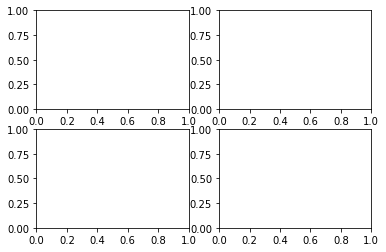

In [ ]:
for id_file in range(args.id_min, args.id_max):

    if args.gpu <= 0:
        import numpy as xp
    else: 
        import cupy as xp
        print("Use GPU " + str(args.gpu))
        #xp.cuda.Device(args.gpu).use()
    filename_oracle = ".pkl"
    if args.oracle :
      filename_oracle = "-oracle" + filename_oracle
    SAVE_PATH = os.path.join("./data/audio/out/",
                                 "{}_{}/alpha={}/".format(args.type,
                                                          args.n_speaker,
                                                          args.alpha))
    
    fileObject2 = open(('./data/audio/out/mixture_nfft={}' + filename_oracle ).format(nfft), 'rb')
    unpickler = pkl.Unpickler(fileObject2)
    mix_spec = unpickler.load().astype(np.complex64)
    fileObject2.close()
    if args.oracle:
      mix_spec = xp.asarray(mix_spec[:,:,:300,:])
    else:
      mix_spec = xp.asarray(mix_spec[:,:300,:])
    
    
    if args.update_psi:
        method_name = 'Alpha-Psi_MNMF'
    else:
        method_name = 'Alpha_MNMF'
    
    Separater = Alpha_MNMF(alpha=args.alpha,
                                       n_basis=args.n_basis, n_source= args.n_speaker,
                                       nb_Theta=args.n_Th, seed=args.seed,
                                       xp=xp, acoustic_model='far',
                                       update_psi=args.update_psi,
                                       oracle=args.oracle)
    Separater.load_spectrogram(mix_spec)
    Separater.file_id = id_file
    Separater.solve(n_iteration=args.n_iteration, save_likelihood=False,
                                save_parameter=False, save_wav=True,
                                save_path=SAVE_PATH,
                                interval_save_parameter=args.n_inter)